## GAN Atomic Example on MNIST

Very simple example of Generative Adversarial Network generating
sample from MNIST dataset.

(takes 8 min on a 1080ti)

### GAN

In [1]:
import math
import torch as t
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch.nn.functional as F


t.manual_seed(0)

def visualize(image_tensor, num_images=10, size=(1, 28, 28),
                       img_side=5, dpi=100):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=10)
    figure(dpi=dpi, figsize=(num_images * img_side, img_side))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

    
def gen_noise(n_samples, z_dim, device='cpu'):
    return t.randn(n_samples, z_dim).to(device)

In [2]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self._g = nn.Sequential(
            self._g_block(z_dim, hidden_dim),
            self._g_block(hidden_dim, hidden_dim * 2),
            self._g_block(hidden_dim * 2, hidden_dim * 4),
            self._g_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
        
    def _g_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True))

    def forward(self, noise):
        return self._g(noise)    


class Discriminator(nn.Module):
    
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self._d = nn.Sequential(
            self._d_block(im_dim, hidden_dim * 4),
            self._d_block(hidden_dim * 4, hidden_dim * 2),
            self._d_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1))
        
    def _d_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(0.2))

    def forward(self, image):
        return self._d(image)
    

class GAN: 
    
    def __init__(self, z_dim, criterion, lr, device):    
        self._g = Generator(z_dim).to(device)
        self._g_opt = t.optim.Adam(self._g.parameters(), lr=lr)
        
        self._d = Discriminator().to(device) 
        self._d_opt = t.optim.Adam(self._d.parameters(), lr=lr)

        self._z_dim = z_dim
        self._criterion = criterion
        self._device = device
        
    def _calc_d_loss(self, batch_real, num_images):
        # Generate noise image nad get sample from G
        z = gen_noise(num_images, self._z_dim, self._device)
        fake_samples = self._g(z)

        # Get D's prediction for fake images
        y_fake_ = self._d(fake_samples.detach())
        fake_loss = self._criterion(y_fake_, t.zeros_like(y_fake_))

        # Get D's predition of real images
        y_real_ = self._d(batch_real)
        real_loss = self._criterion(y_real_, t.ones_like(y_real_))

        _d_loss = (fake_loss + real_loss) / 2.

        return _d_loss

    def _calc_g_loss(self, num_images):
        # Generate fake images from noise vector
        z = gen_noise(num_images, self._z_dim, self._device)
        fake_samples = self._g(z)

        # Get D's prediction for the fake images
        y_ = self._d(fake_samples)
        _g_loss = self._criterion(y_, t.ones_like(y_))

        return _g_loss
    
    def _update_step(self, batch_real, flatten_batch=True, *args):
        num_images = len(batch_real)
        if flatten_batch:
            batch_real = batch_real.view(num_images, -1)
        batch_real = batch_real.to(self._device)
        
        # D update
        self._d_opt.zero_grad()
        d_loss = self._calc_d_loss(batch_real, num_images)
        d_loss.backward(retain_graph=True)
        self._d_opt.step()
        
        # G update
        self._g_opt.zero_grad()
        g_loss = self._calc_g_loss(num_images)
        g_loss.backward()
        self._g_opt.step()
        
        return d_loss.item(), g_loss.item()
    
    @property
    def G(self):
        return self._g

In [3]:
class Trainer:
    
    def __init__(self, data_loader, model, batch_size=128, device='cuda:0'):
        self.batch_size = batch_size
        self.dataloader = data_loader
        self.model = model
    
    def run(self, n_epochs, display_epoch=10, **kwargs):
        update_step = 0        # Total udpate step
        epoch_update_step = 0  # Update step within epoch
        mean_g_loss = 0        # Meach G loss for epoch
        mean_d_loss = 0        # Meach D loss for epoch
        display_epoch = 10     # Visualize once in 
        device = config['device']

        for epoch in tqdm(range(n_epochs)):  
            for batch_real, labels in self.dataloader:
                cur_batch_size = len(batch_real)
                
                d_loss, g_loss = self.model._update_step(batch_real,
                                                         labels=labels, **kwargs)
                mean_d_loss += d_loss
                mean_g_loss += g_loss

                epoch_update_step += 1

            # Calc mean loss for the epoch
            mean_d_loss /= epoch_update_step
            mean_g_loss /= epoch_update_step
            update_step += epoch_update_step
            epoch_update_step = 0

            # Visualize
            if epoch % display_epoch == 0:
                print(f"Epoch {epoch} Step {update_step}: G loss: {mean_g_loss}, D loss: {mean_d_loss}")
                fake_noise = gen_noise(cur_batch_size, config['z_dim'], device=config['device'])
                fake = self.model.G(fake_noise)
                visualize(fake)
                mean_g_loss = 0
                mean_d_loss = 0

Epoch 0 Step 469: G loss: 1.3656138376132259, D loss: 0.4240699731973189


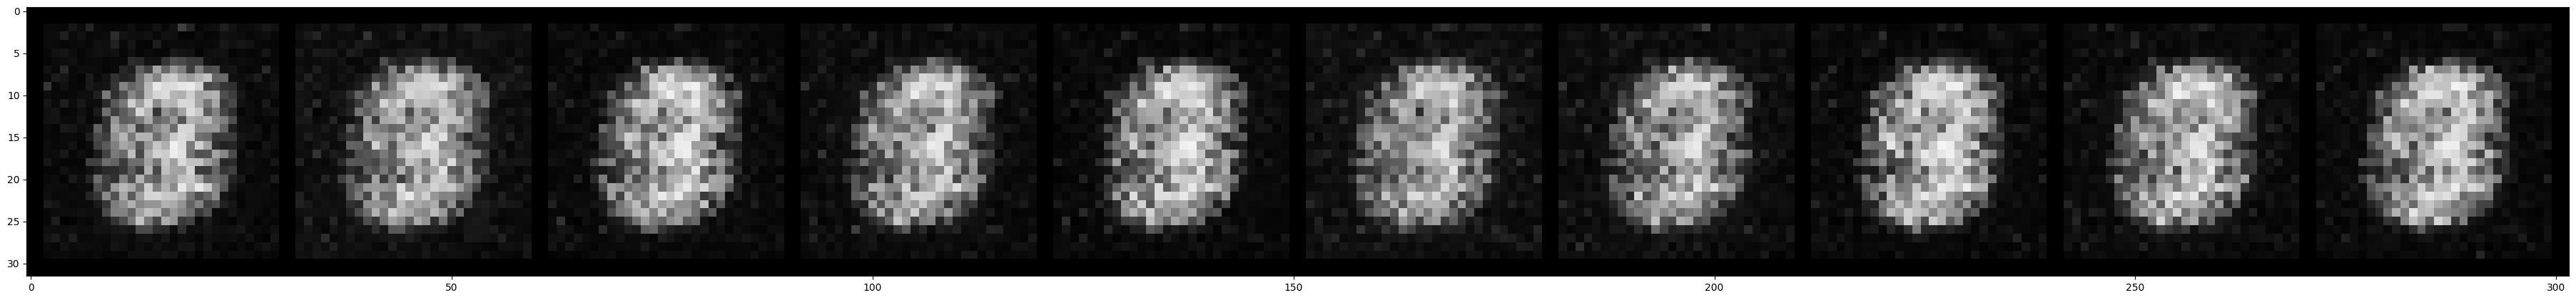

Epoch 10 Step 5159: G loss: 3.3743586700821258, D loss: 0.08670926811339168


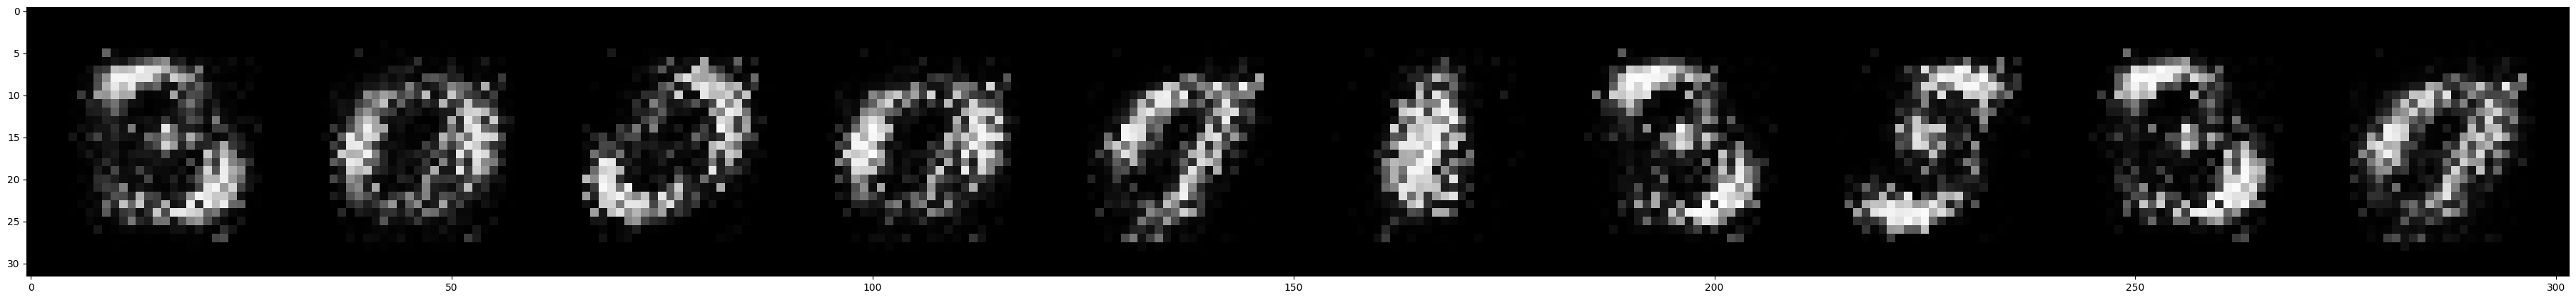

Epoch 20 Step 9849: G loss: 3.7620362613650165, D loss: 0.07860342110287001


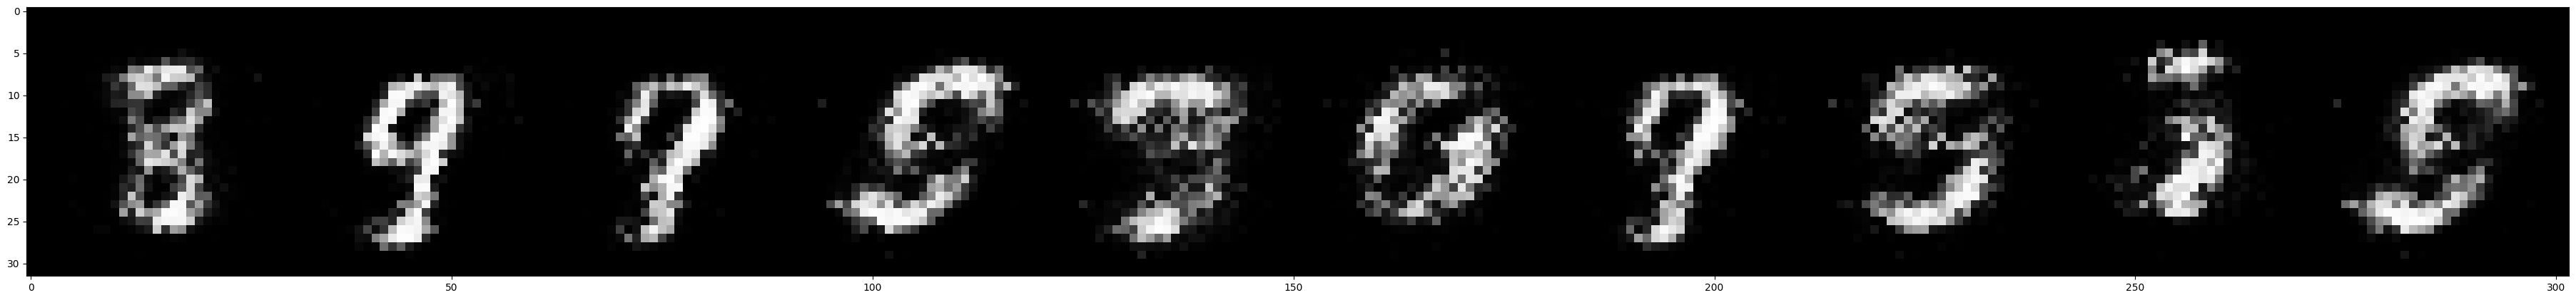

Epoch 30 Step 14539: G loss: 3.6355717739954474, D loss: 0.10340661433911881


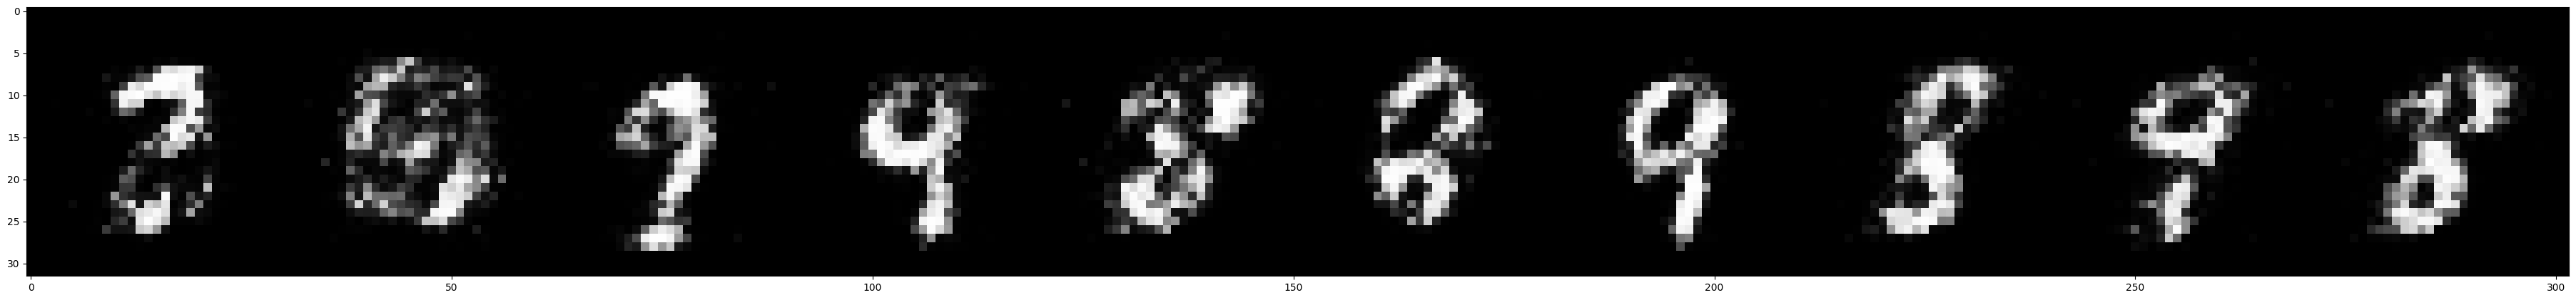

Epoch 40 Step 19229: G loss: 3.192093383101483, D loss: 0.16366776505767303


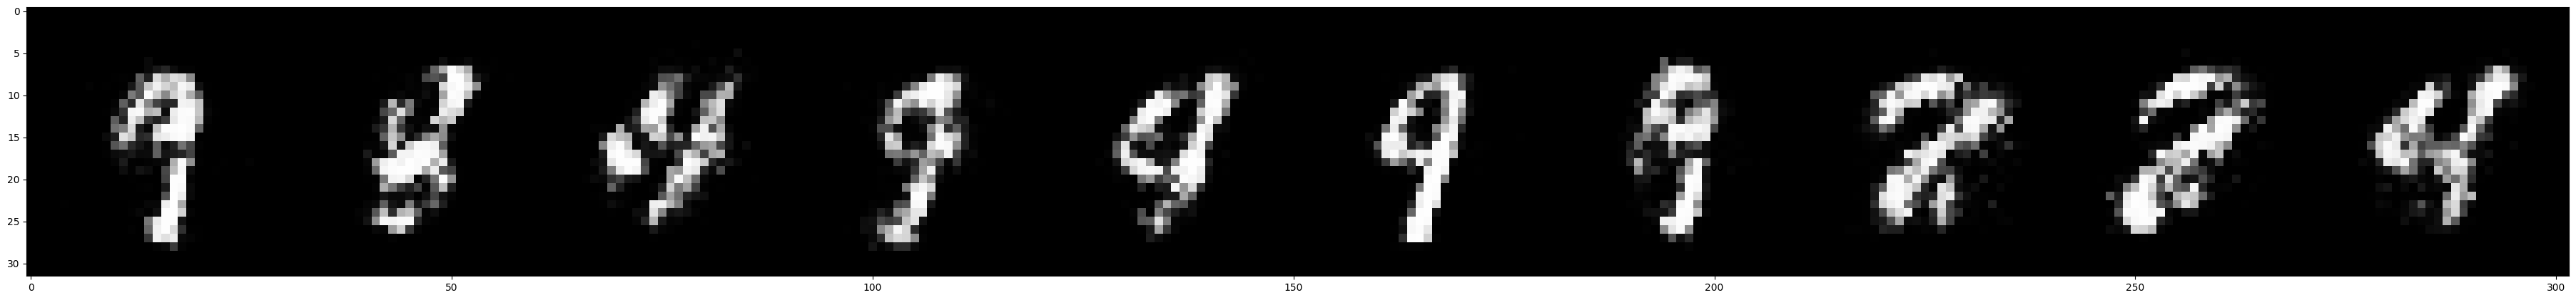

Epoch 50 Step 23919: G loss: 2.924265062936034, D loss: 0.19279980711209826


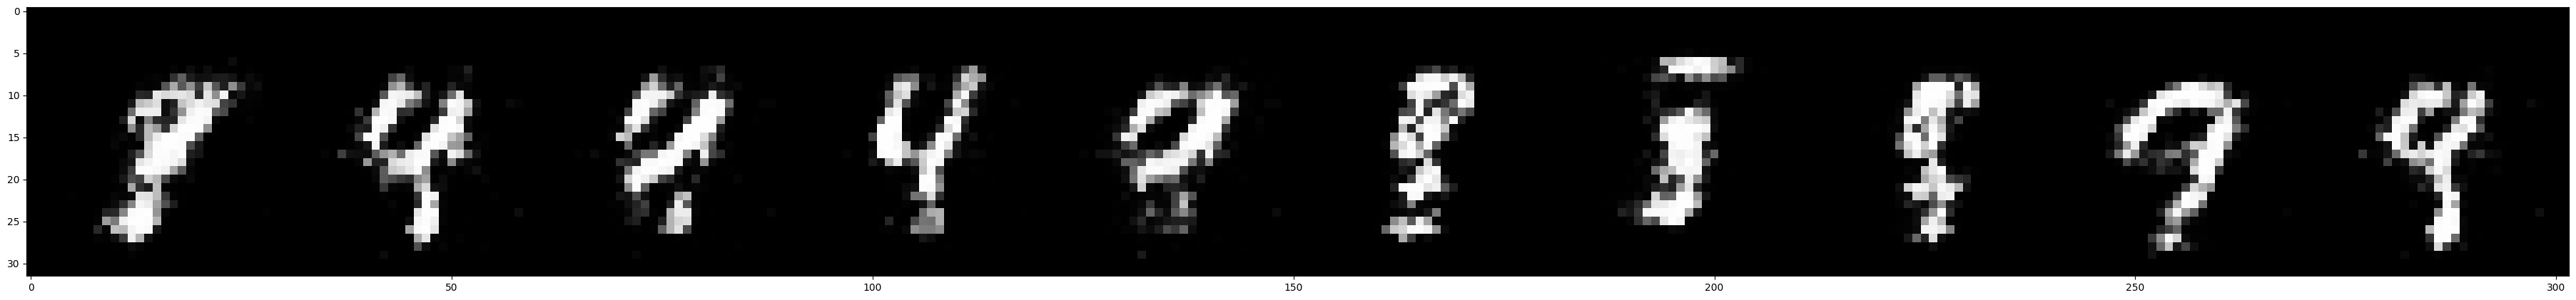

Epoch 60 Step 28609: G loss: 2.648690366689145, D loss: 0.2338616864522567


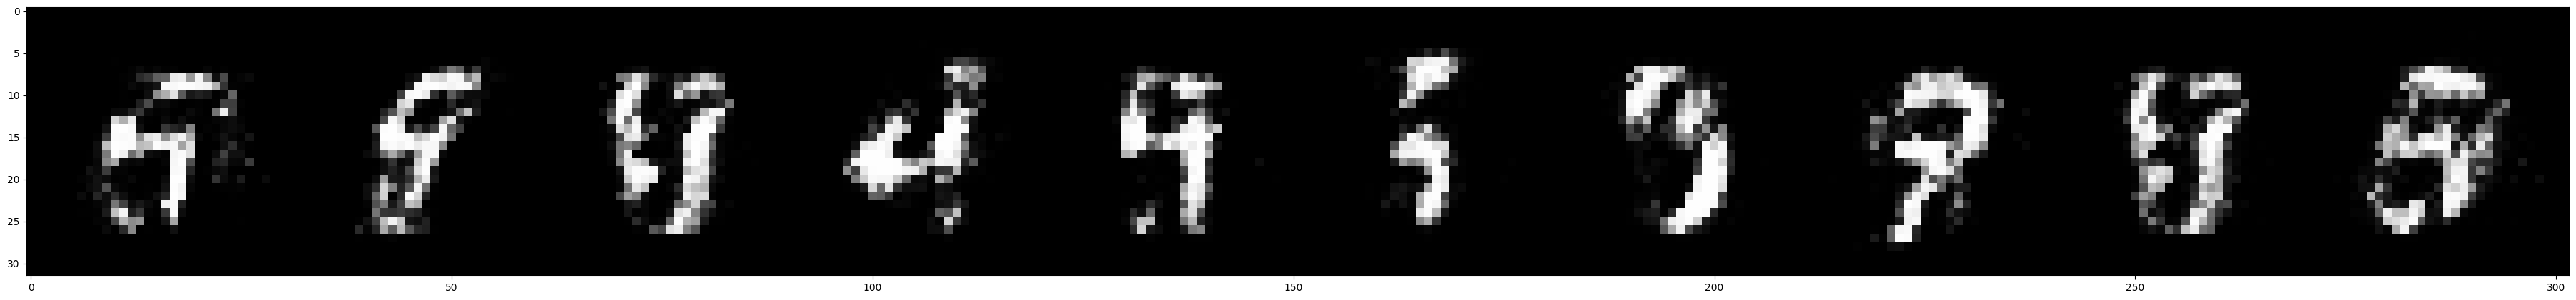

Epoch 70 Step 33299: G loss: 2.4466281397117666, D loss: 0.2419262544679208


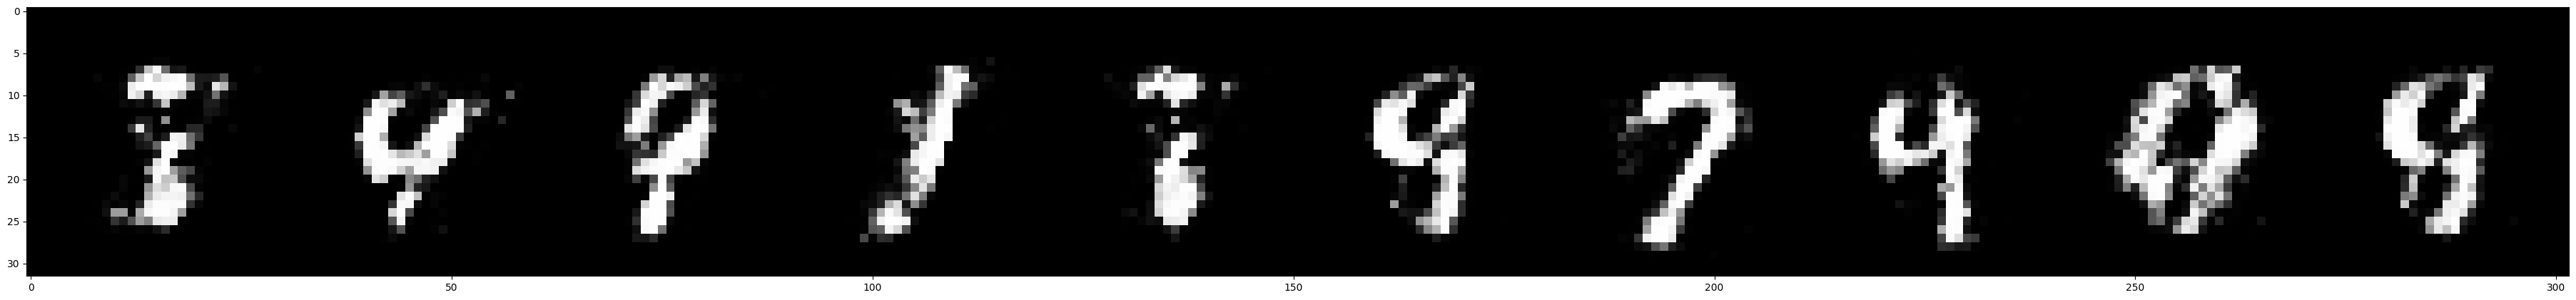

Epoch 80 Step 37989: G loss: 2.382195695226715, D loss: 0.2631102699423095


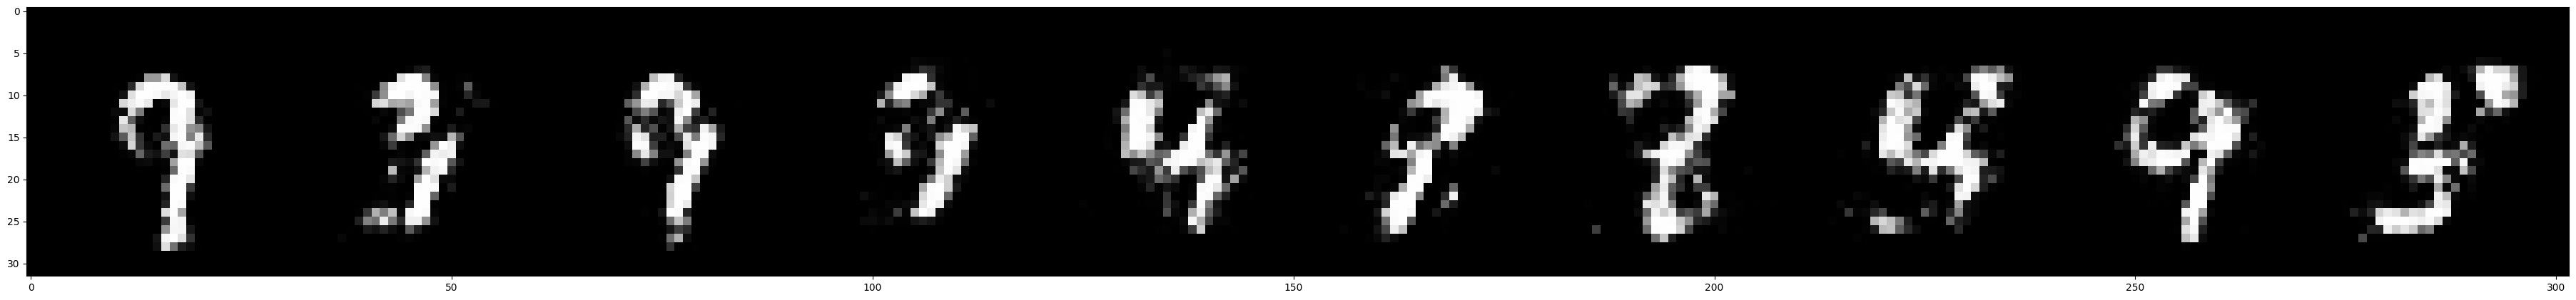

Epoch 90 Step 42679: G loss: 2.18981036084225, D loss: 0.28139698715143147


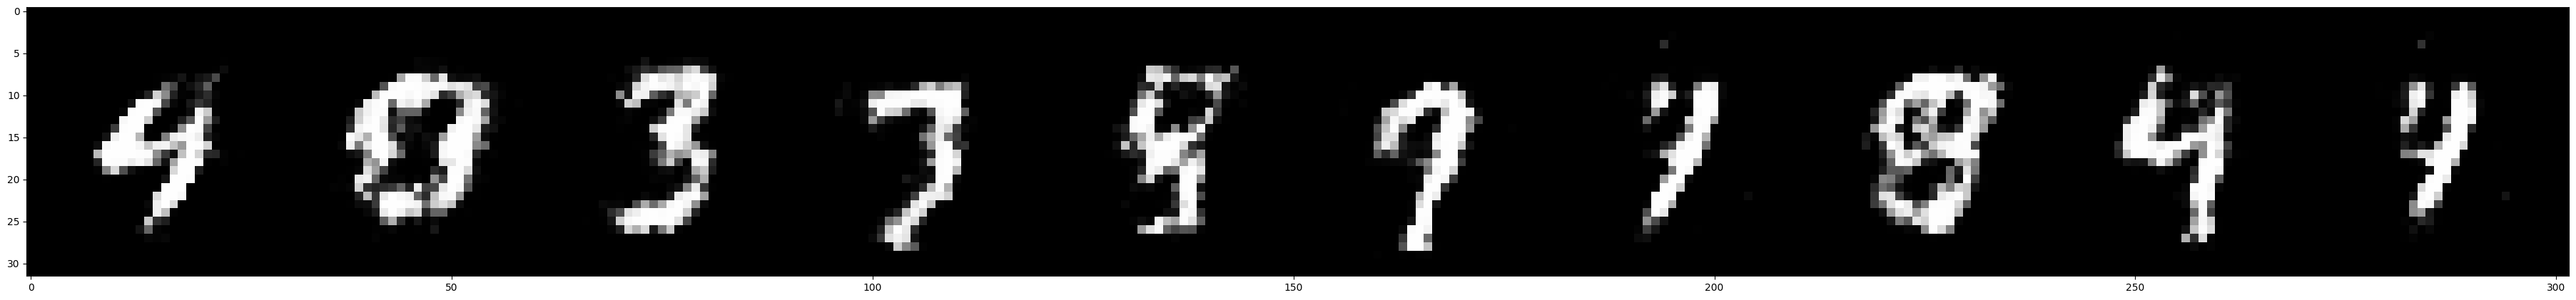


CPU times: user 8min 54s, sys: 1.03 s, total: 8min 55s
Wall time: 8min 49s


In [4]:
%%time

# Load MNIST dataset
batch_size = 128
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

config = {
    'criterion': nn.BCEWithLogitsLoss(),
    'z_dim': 64,
    'lr': 0.00001,
    'device': 'cuda:0'
}
model = GAN(**config)

trainer = Trainer(dataloader, model)
trainer.run(n_epochs=100)

## DCGAN

In [4]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=10, n_channels=1, hidden_dim=64):
        super(DCGenerator, self).__init__()
        self.z_dim = z_dim

        self._g = nn.Sequential(
            self._g_block(z_dim, hidden_dim * 4),
            self._g_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self._g_block(hidden_dim * 2, hidden_dim),
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim, n_channels, kernel_size=4, stride=2),
                nn.Tanh())
        )

    def _g_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        ''' TransConv -> BN -> Activation. '''
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU())
            
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self._g(x)


class DCDiscriminator(nn.Module):
    def __init__(self, n_channels=1, hidden_dim=16):
        super(DCDiscriminator, self).__init__()
        self._d = nn.Sequential(
            self._d_block(n_channels, hidden_dim),
            self._d_block(hidden_dim, hidden_dim * 2),
            nn.Sequential(
                nn.Conv2d(hidden_dim * 2, 1, kernel_size=4, stride=2)
            ))

    def _d_block(self, input_channels, output_channels, kernel_size=4, stride=2):
        ''' Conv -> BN -> Activation. '''
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2))

    def forward(self, image):
        disc_pred = self._d(image)
        return disc_pred.view(len(disc_pred), -1)
    


def _init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        t.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        t.nn.init.normal_(m.weight, 0.0, 0.02)
        t.nn.init.constant_(m.bias, 0)


class DCGAN(GAN): 
    
    def __init__(self, z_dim, criterion, lr, betas, device):
        self._g = DCGenerator(z_dim).to(device)
        self._g_opt = t.optim.Adam(self._g.parameters(), 
                                   lr=lr, betas=betas)
        
        self._d = DCDiscriminator().to(device) 
        self._d_opt = t.optim.Adam(self._d.parameters(),
                                   lr=lr, betas=betas)
        
        # Initialize weights
        self._g = self._g.apply(_init_weights)
        self._d = self._d.apply(_init_weights)
        
        self._z_dim = z_dim
        self._criterion = criterion
        self._device = device

Epoch 0 Step 469: G loss: 0.9897839067333034, D loss: 0.5028498146071363


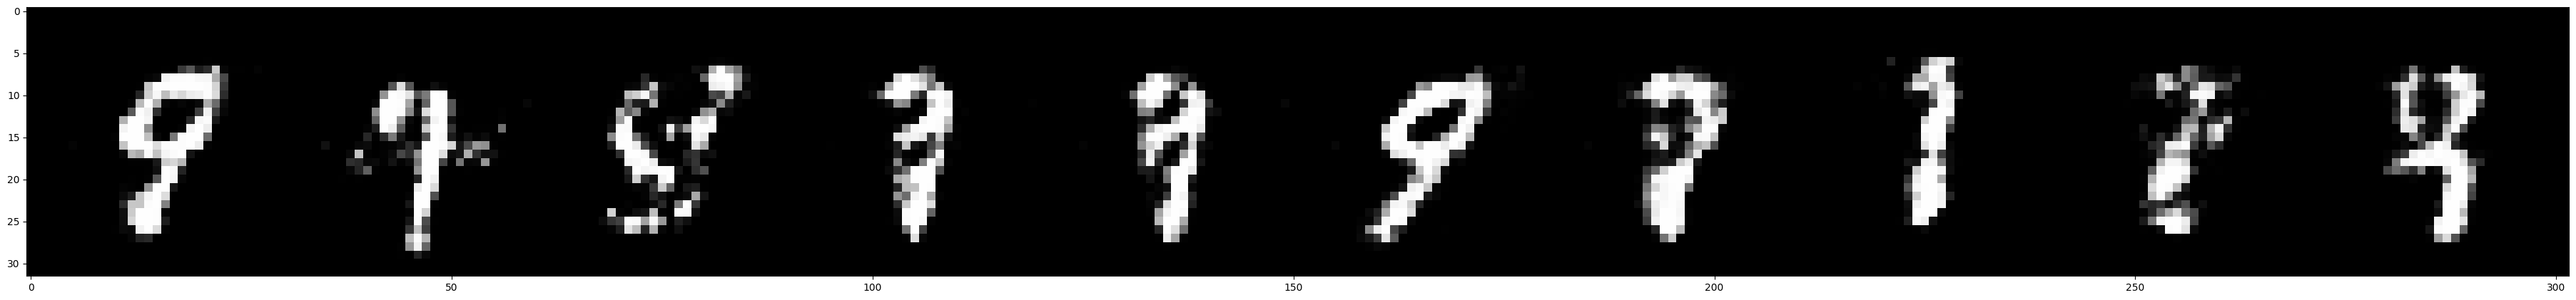

Epoch 10 Step 5159: G loss: 0.7820678419433338, D loss: 0.6617574389235842


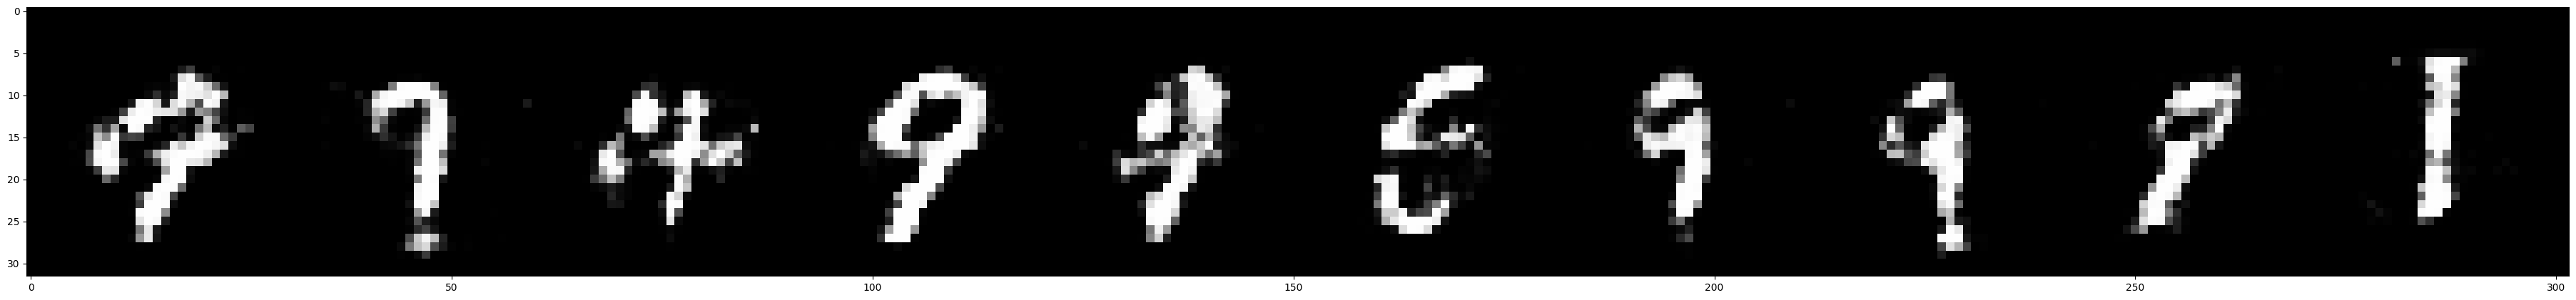

Epoch 20 Step 9849: G loss: 0.727734934974762, D loss: 0.6901514728611228


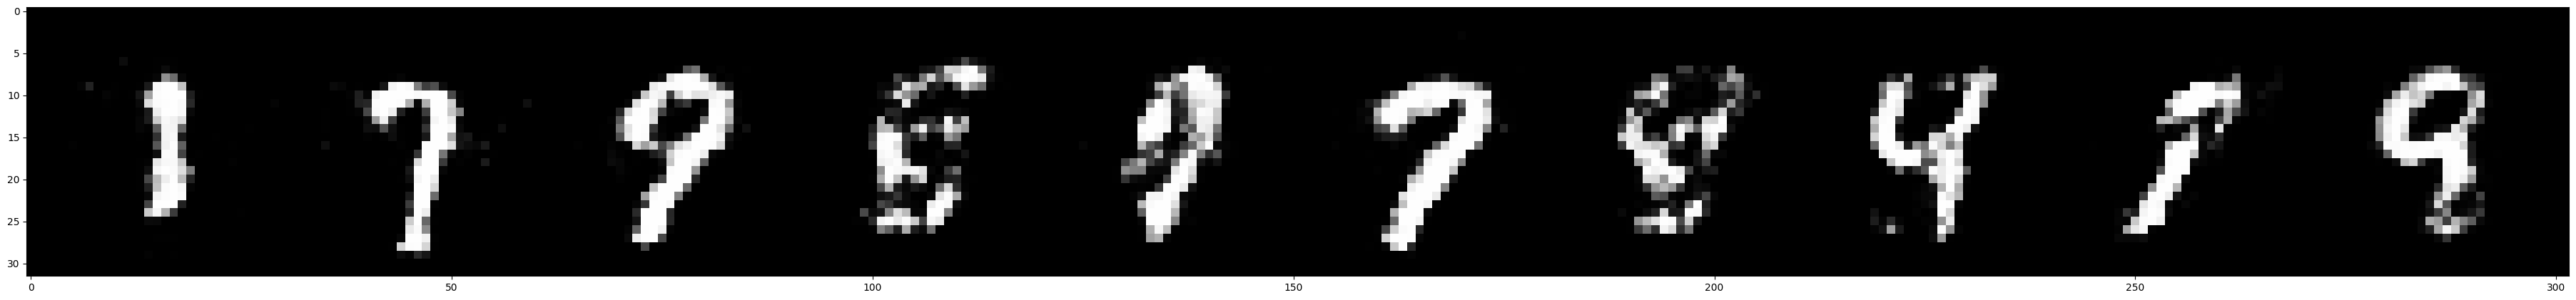

Epoch 30 Step 14539: G loss: 0.7009812661703613, D loss: 0.7012255512832244


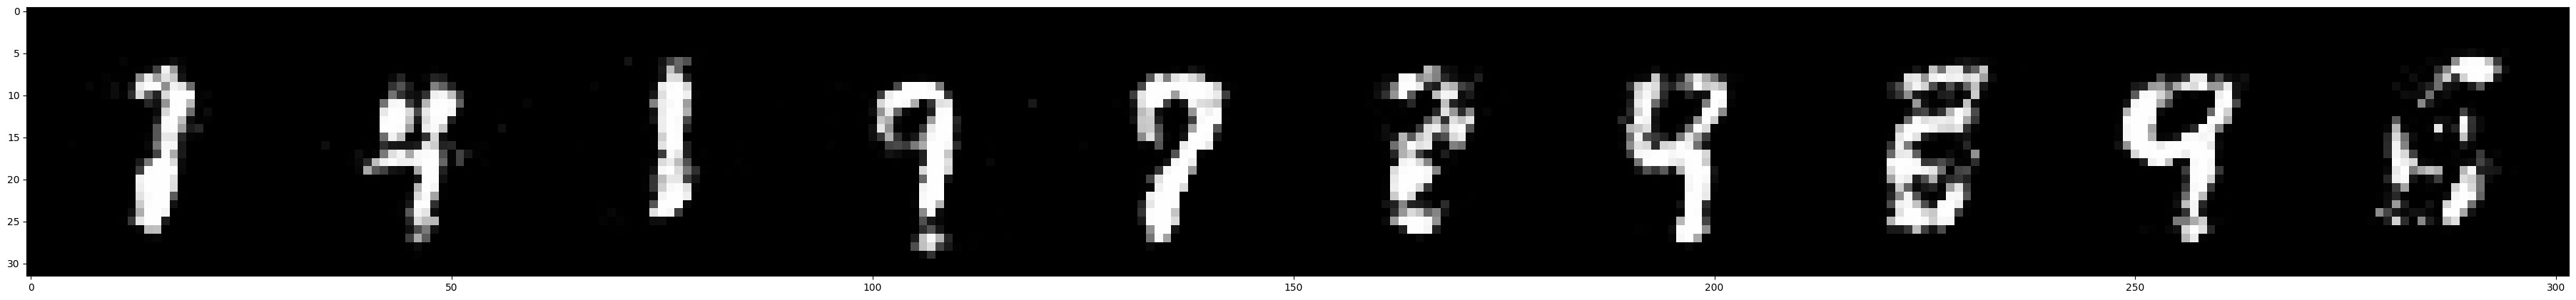


CPU times: user 5min 33s, sys: 331 ms, total: 5min 34s
Wall time: 5min 32s


In [6]:
%%time

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset
batch_size = 128
dc_dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

config = {
    'criterion': nn.BCEWithLogitsLoss(),
    'z_dim': 64,
    'lr': 0.0002,
    'betas': (0.5, 0.999),
    'device': 'cuda:0'
}
dc_model = DCGAN(**config)
dc_trainer = Trainer(dc_dataloader, dc_model)
dc_trainer.run(n_epochs=31, display_epoch=5, flatten_batch=False)

## Contidional GAN

In [5]:
def calc_one_hot(labels, n_classes):
    oh = F.one_hot(labels.flatten(), n_classes).float()
    return oh.unsqueeze(0)


class ConditionalGAN(GAN): 
    
    def __init__(self, z_dim, criterion, lr, betas, device,
                 n_classes=10, data_shape=(1, 28, 28)):
        
        
        gen_dim = z_dim + n_classes        
        self._g = DCGenerator(gen_dim).to(device)
        self._g_opt = t.optim.Adam(self._g.parameters(), 
                                   lr=lr, betas=betas)
        
        d_dim = data_shape[0] + n_classes
        self._d = DCDiscriminator(d_dim).to(device) 
        self._d_opt = t.optim.Adam(self._d.parameters(),
                                   lr=lr, betas=betas)
        
        # Initialize weights
        self._g = self._g.apply(_init_weights)
        self._d = self._d.apply(_init_weights)
        
        self._z_dim = z_dim
        self._criterion = criterion
        self._device = device
        self._n_classes = n_classes
        self._data_shape = data_shape
        
    def _update_step(self, real, labels, **kwargs):
        # Move to cuda
        real = real.to(self._device)
        labels = labels.to(self._device)
        
        # Get noise corresponding to the current batch_size 
        one_hot_labels = calc_one_hot(labels, self._n_classes).squeeze(0)
        b_size = len(labels)
        z = gen_noise(b_size, self._z_dim, device=self._device)
        z_and_labels = t.cat([z, one_hot_labels], dim=-1)
        fake = self._g(z_and_labels)
    
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, self._data_shape[1], self._data_shape[2])
        
        d_loss = self._update_discriminator(real, fake, image_one_hot_labels)
        g_loss = self._update_generator(fake, image_one_hot_labels)
        
        return d_loss, g_loss
        
    def _update_discriminator(self, real, fake, image_one_hot_labels):
        
        self._d_opt.zero_grad()
        
        '''
        # Get noise corresponding to the current batch_size 
        z = gen_noise(cur_batch_size, self._z_dim, device=self._device)
        z_and_labels = t.cat([z, one_hot_labels], dim=-1)
        fake = self._g(z_and_labels)
        '''

        fake_image_and_labels = t.cat([fake, image_one_hot_labels], dim=1)
        real_image_and_labels = t.cat([real, image_one_hot_labels], dim=1)
        d_fake_pred = self._d(fake_image_and_labels)
        d_real_pred = self._d(real_image_and_labels)
        
        d_fake_loss = self._criterion(d_fake_pred, t.zeros_like(d_fake_pred))
        d_real_loss = self._criterion(d_real_pred, t.ones_like(d_real_pred))
        d_loss = (d_fake_loss + d_real_loss) / 2
        d_loss.backward(retain_graph=True)
        self._d_opt.step() 
        
        return d_loss

    def _update_generator(self, fake, image_one_hot_labels):

        self._g_opt.zero_grad()
        
        fake_image_and_labels = t.cat([fake, image_one_hot_labels], dim=1)
        d_fake_pred = self._d(fake_image_and_labels)
        
        g_loss = self._criterion(d_fake_pred, t.ones_like(d_fake_pred))
        g_loss.backward()
        self._g_opt.step()

                
        return g_loss

'''
class ConditionalTrainer:
    
    def __init__(self, data_loader, model, batch_size=128, device='cuda:0'):
        self.batch_size = batch_size
        self.dataloader = data_loader
        self.model = model
    
    def run(self, n_epochs, display_epoch=10, flatten_batch=True):
        update_step = 0        # Total udpate step
        epoch_update_step = 0  # Update step within epoch
        mean_g_loss = 0        # Meach G loss for epoch
        mean_d_loss = 0        # Meach D loss for epoch
        display_epoch = 10     # Visualize once in 
        device = config['device']
        n_classes = 10

        for epoch in tqdm(range(n_epochs)):  
            for batch_real, labels in self.dataloader:
                cur_batch_size = len(batch_real)
                
                d_loss, g_loss = self.model._update_step(batch_real, labels)
                mean_d_loss += d_loss
                mean_g_loss += g_loss

                epoch_update_step += 1

            # Calc mean loss for the epoch
            mean_d_loss /= epoch_update_step
            mean_g_loss /= epoch_update_step
            update_step += epoch_update_step
            epoch_update_step = 0

            # Visualize
            if epoch % display_epoch == 0:
                print(f"Epoch {epoch} Step {update_step}: G loss: {mean_g_loss}, D loss: {mean_d_loss}")
                fake_noise = gen_noise(cur_batch_size, config['z_dim'], device=config['device'])
                fake = model.G(fake_noise)
                visualize(fake)
                mean_g_loss = 0
                mean_d_loss = 0
'''
                
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset
batch_size = 128
dc_dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

config = {
    'criterion': nn.BCEWithLogitsLoss(),
    'z_dim': 64,
    'lr': 0.0002,
    'betas': (0.5, 0.999),
    'device': 'cuda:0'
}
c_model = ConditionalGAN(**config)
c_trainer = Trainer(dc_dataloader, c_model)
c_trainer.run(n_epochs=41, display_epoch=5, flatten_batch=False)

Epoch 0 Step 469: G loss: 0.8993626832962036, D loss: 0.5574716925621033



RuntimeError: shape '[96, 74, 1, 1]' is invalid for input of size 6144

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 576x576 with 0 Axes>

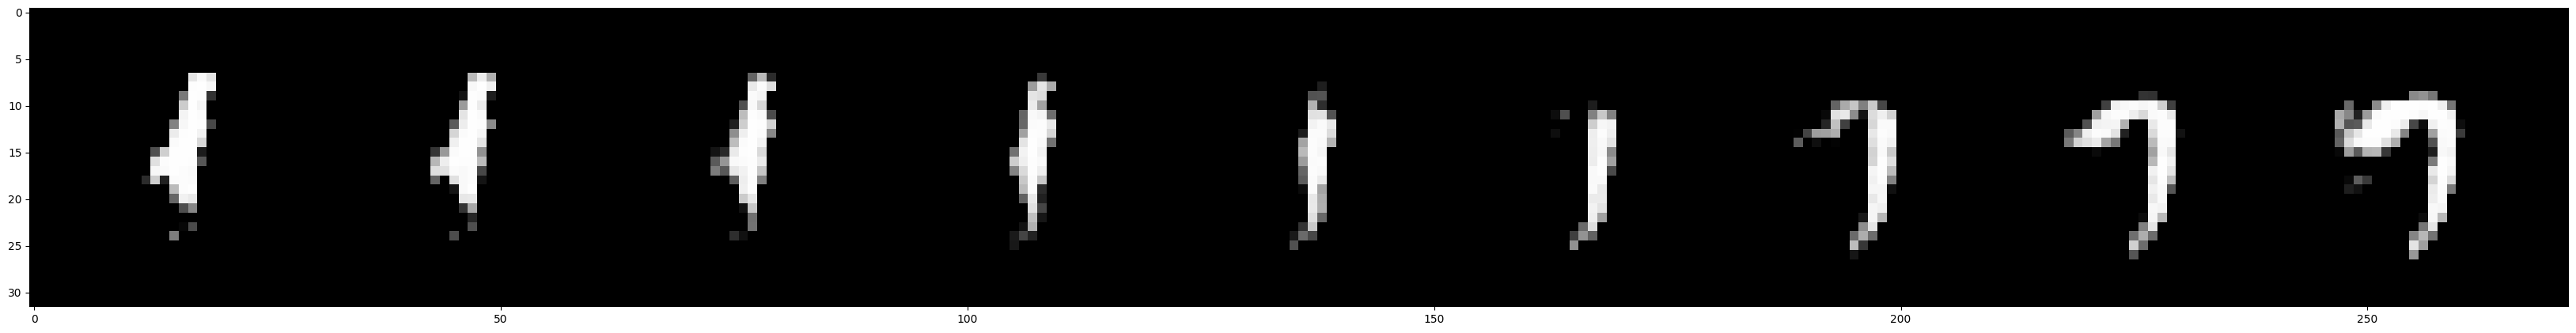

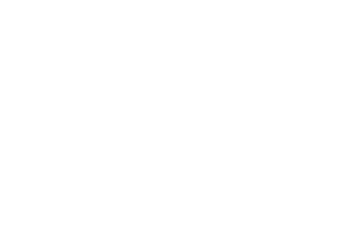

In [50]:
gen = c_model.G.eval()

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = gen_noise(1, z_dim).repeat(n_interpolation, 1)

def interpolate_classes(first_number, second_number):
    first_label = calc_one_hot(torch.Tensor([first_number]).long(), n_classes)
    second_label = calc_one_hot(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = t.cat([interpolation_noise, interpolation_labels.squeeze(0)], dim=1).to(device)
    fake = gen(noise_and_labels)
    visualize(fake, num_images=n_interpolation)


digit_1 = 1
digit_2 = 7

plt.figure(figsize=(8, 8))
interpolate_classes(digit_1, digit_2)
_ = plt.axis('off')